In [0]:
! pip install numpy==1.17.0
! pip install folium==0.8.3
! pip install imgaug==0.2.9
! pip install -U protobuf==3.8.0

Requirement already up-to-date: protobuf==3.8.0 in /usr/local/lib/python3.6/dist-packages (3.8.0)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

caltech_dir_ap = "/content/drive/My Drive/home/pi/CarLicensePlate/train_img"   #add_parking과 add_noparking폴더를 가지고 있는 큰 카테고리 
categories_ap = ["add_parking","add_noparking"]  #car와 no_car로 나누기
nb_classes_ap = len(categories_ap)

image_w_ap = 64
image_h_ap = 64

pixels_ap = image_h_ap * image_w_ap * 3

X_ap = []
y_ap = []

for idx, cat_ap in enumerate(categories_ap):  

    #one-hot 돌리기.
    label_ap = [0 for i in range(nb_classes_ap)]
    label_ap[idx] = 1

    image_dir_ap = caltech_dir_ap + "/" + cat_ap
    files_ap = glob.glob(image_dir_ap+"/*.png")
    print(cat_ap, " 파일 길이 : ", len(files_ap))
    for i, f_ap in enumerate(files_ap):
        img_ap = Image.open(f_ap)
        img_ap = img_ap.convert("RGB")
        img_ap= img_ap.resize((image_w_ap, image_h_ap))
        data_ap = np.asarray(img_ap)

        X_ap.append(data_ap)
        y_ap.append(label_ap)

        if i % 700 == 0:
            print(cat_ap, " : ", f_ap)

X_ap = np.array(X_ap)
y_ap= np.array(y_ap)

    #1 0 이면 주차된 사진
    #0 1 이면 주차되지 않은 사진

X_train_ap, X_test_ap, y_train_ap, y_test_ap = train_test_split(X_ap, y_ap)
xy_ap= (X_train_ap, X_test_ap, y_train_ap, y_test_ap)
np.save('/content/drive/My Drive/home/pi/CarLicensePlate/car_img_data_AnP.npy', xy_ap)


add_parking  파일 길이 :  500
add_parking  :  /content/drive/My Drive/home/pi/CarLicensePlate/train_img/add_parking/car_ha_1_0_1146.png
add_noparking  파일 길이 :  500
add_noparking  :  /content/drive/My Drive/home/pi/CarLicensePlate/train_img/add_noparking/nopark_0_3118.png


In [0]:
import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K
import tensorflow as tf

config_ap = tf.compat.v1.ConfigProto()
config_ap.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config_ap)

X_train_ap, X_test_ap, y_train_ap, y_test_ap = np.load('/content/drive/My Drive/home/pi/CarLicensePlate/car_img_data_AnP.npy',allow_pickle=True)

Using TensorFlow backend.


In [0]:
categories_ap = ["add_parking","add_noparking"]   #car와 no_car로 나누기
nb_classes_ap = len(categories_ap)

#일반화
X_train_ap = X_train_ap.astype(float) / 255
X_test_ap = X_test_ap.astype(float) / 255

In [0]:
with K.tf_ops.device('/device:GPU:0'):
    model_ap = Sequential()
    model_ap.add(Conv2D(32, (3,3), padding="same", input_shape=X_train_ap.shape[1:], activation='relu'))
    model_ap.add(MaxPooling2D(pool_size=(2,2)))
    model_ap.add(Dropout(0.25))

    model_ap.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model_ap.add(MaxPooling2D(pool_size=(2,2)))
    model_ap.add(Dropout(0.25))

    model_ap.add(Flatten())
    model_ap.add(Dense(256, activation='relu'))
    model_ap.add(Dropout(0.5))
    model_ap.add(Dense(nb_classes_ap, activation='sigmoid'))
    model_ap.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir_ap = './model'

    if not os.path.exists(model_dir_ap):
        os.mkdir(model_dir_ap)

    model_path_ap = model_dir_ap + '/parking_img_classification_1.model'
    checkpoint = ModelCheckpoint(filepath=model_path_ap , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)


In [0]:
model_ap.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

In [0]:
history_ap = model_ap.fit(X_train_ap, y_train_ap, batch_size=3, epochs=10, validation_data=(X_test_ap, y_test_ap), callbacks=[checkpoint, early_stopping])

Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 25s 33ms/step - loss: 0.1544 - accuracy: 0.9367 - val_loss: 0.0107 - val_accuracy: 0.9960

Epoch 00001: val_loss improved from inf to 0.01069, saving model to ./model/parking_img_classification_1.model
Epoch 2/10
750/750 [==============================] - 24s 32ms/step - loss: 0.0183 - accuracy: 0.9940 - val_loss: 6.1632e-04 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.01069 to 0.00062, saving model to ./model/parking_img_classification_1.model
Epoch 3/10
750/750 [==============================] - 24s 32ms/step - loss: 0.0354 - accuracy: 0.9947 - val_loss: 5.0779e-04 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.00062 to 0.00051, saving model to ./model/parking_img_classification_1.model
Epoch 4/10
750/750 [==============================] - 24s 32ms/step - loss: 0.0160 - accuracy: 0.9973 - val_loss: 8.9171e-05 - val_accuracy: 1.0000

Epoch 00004: val_loss

In [0]:
print("정확도 : %.4f" % (model_ap.evaluate(X_test_ap, y_test_ap)[1]))

250/250 [==============================] - 0s 2ms/step
정확도 : 1.0000


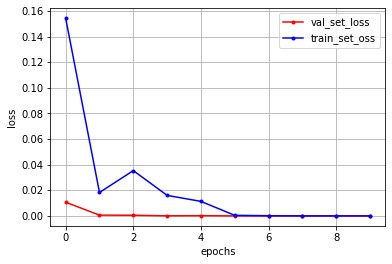

In [0]:
y_vloss_ap = history_ap.history['val_loss']
y_loss_ap = history_ap.history['loss']

x_len_ap = np.arange(len(y_loss_ap))

plt.plot(x_len_ap, y_vloss_ap, marker='.', c='red', label='val_set_loss')
plt.plot(x_len_ap, y_loss_ap, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

In [0]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = '/content/drive/My Drive/home/pi/CarLicensePlate/test_img'  #테스트셋 카테고리 경로
image_w_ap = 64
image_h_ap = 64

pixels_ap = image_h_ap * image_w_ap * 3

X_ap = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img_ap = Image.open(f)
    img_ap = img_ap.convert("RGB")
    img_ap= img_ap.resize((image_w_ap, image_h_ap))
    data_ap = np.asarray(img_ap)
    filenames.append(f)
    X_ap.append(data_ap)

X_ap = np.array(X_ap)
model_ap = load_model('./model/parking_img_classification_1.model')   #CNN모델 불러옴 
prediction_ap = model_ap.predict(X_ap)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#for i in prediction_ap:
#    pre_ans_ap = i.argmax()  # 예측 레이블
#    if i >= 0.5 :
#        print("해당 " + filenames[cnt].split("\\")[1] + filenames[cnt].split("\\")[2] + "   주차 완료입니다.")  
#    else :
#       print("해당 " + filenames[cnt].split("\\")[1] + filenames[cnt].split("\\")[2] + "  주차 상태가 아닙니다.")        
#    cnt += 1

for i in prediction_ap:
    pre_ans_ap = i.argmax()  # 예측 레이블
    pre_ans_str_ap = ''

    if pre_ans_ap == 0: 
      pre_ans_str_ap = "주차완료"
    else: pre_ans_str_ap = "주차 상태 아님"
    
    print(i,'\n')

    if pre_ans_ap > 0.5 : 
      print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 "+pre_ans_str_ap+"으로 추정됩니다.")
    else : 
      print("해당 "+filenames[cnt].split("\\")[0]+"이미지는 "+pre_ans_str_ap+"로 추정됩니다.")
    cnt += 1

[1.000 0.000] 

해당 /content/drive/My Drive/home/pi/CarLicensePlate/test_img/car_ha_1_0_147.png이미지는 주차완료로 추정됩니다.
[1.000 0.000] 

해당 /content/drive/My Drive/home/pi/CarLicensePlate/test_img/car_seo_1_0_147.png이미지는 주차완료로 추정됩니다.
[1.000 0.000] 

해당 /content/drive/My Drive/home/pi/CarLicensePlate/test_img/car_seo_1_0_2070.png이미지는 주차완료로 추정됩니다.
[0.000 1.000] 

해당 /content/drive/My Drive/home/pi/CarLicensePlate/test_img/nopark_0_147.png이미지는 주차 상태 아님으로 추정됩니다.
[0.000 1.000] 

해당 /content/drive/My Drive/home/pi/CarLicensePlate/test_img/nopark_0_1862.png이미지는 주차 상태 아님으로 추정됩니다.
[0.000 1.000] 

해당 /content/drive/My Drive/home/pi/CarLicensePlate/test_img/nopark_0_1681.png이미지는 주차 상태 아님으로 추정됩니다.
[0.000 1.000] 

해당 /content/drive/My Drive/home/pi/CarLicensePlate/test_img/nopark_0_1146.png이미지는 주차 상태 아님으로 추정됩니다.
[0.000 1.000] 

해당 /content/drive/My Drive/home/pi/CarLicensePlate/test_img/nopark_0_916.png이미지는 주차 상태 아님으로 추정됩니다.
[1.000 0.000] 

해당 /content/drive/My Drive/home/pi/CarLicensePlate/test_img/car_rue